In [164]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_curve, auc
import os

In [167]:
def load_data_from_folder(folder, label):
    X = []
    y = []
    
    for file in os.listdir(folder):
        if file.endswith(".npy"):
            file_path = os.path.join(folder, file)
            data = np.load(file_path)  #shape(3,64,64)

            if data.shape == (3, 64, 64):  # Ensure correct shape
                data = np.transpose(data, (1, 2, 0)) #shape(64,64,3)
                X.append(data)
                y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

In [168]:
#path directories of the dataset
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

train_lenses_dir = os.path.join(parent_dir, 'lens-finding-test', 'train_lenses')
train_nonlenses_dir = os.path.join(parent_dir, 'lens-finding-test', 'train_nonlenses')
test_lenses_dir = os.path.join(parent_dir, 'lens-finding-test', 'test_lenses')
test_nonlenses_dir = os.path.join(parent_dir, 'lens-finding-test', 'test_nonlenses')

In [170]:
#getting data from dataset
X_train_lensed, y_train_lensed = load_data_from_folder(train_lenses_dir, 1) #label 1 for lensed
X_train_nonlensed, y_train_nonlensed = load_data_from_folder(train_nonlenses_dir, 0) #label 0 for non lensed

X_test_lensed, y_test_lensed = load_data_from_folder(test_lenses_dir, 1)
X_test_nonlensed, y_test_nonlensed = load_data_from_folder(test_nonlenses_dir, 0)


In [213]:
X_train_nonlensed.shape

(28675, 64, 64, 3)

In [172]:
X_train = np.concatenate([X_train_lensed, X_train_nonlensed], axis=0)
y_train = np.concatenate([y_train_lensed, y_train_nonlensed], axis=0)

In [173]:
def oversample(X_minority, y_minority, target_size):
    current_size = len(X_minority)
    if current_size >= target_size:
        return X_minority, y_minority  # No need to oversample

    # Randomly duplicate samples
    indices = np.random.choice(current_size, size=(target_size - current_size), replace=True)
    X_oversampled = np.concatenate([X_minority, X_minority[indices]])
    y_oversampled = np.concatenate([y_minority, y_minority[indices]])

    return X_oversampled, y_oversampled

In [176]:
target_size = len(X_train_nonlensed) #calculating target size for train data

In [177]:
# oversampling of minority class in train data
X_lensed_resampled, y_lensed_resampled = oversample(X_train_lensed, y_train_lensed, target_size)

In [178]:
# combine train data
X_balanced = np.concatenate([X_lensed_resampled, X_train_nonlensed])
y_balanced = np.concatenate([y_lensed_resampled, y_train_nonlensed])

In [204]:
# combine test data
X_test = np.concatenate([X_test_lensed, X_test_nonlensed])
y_test = np.concatenate([y_test_lensed, y_test_nonlensed])

In [205]:
X_test.shape

(19650, 64, 64, 3)

In [179]:
#making batches of data to avoid RAM crash
def data_generator(X, y, batch_size=64):
    num_samples = len(y)
    indices = np.arange(num_samples)

    while True:  
        np.random.shuffle(indices)  
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            yield X[batch_indices], y[batch_indices]

In [180]:
#shuffling train data
indices = np.random.permutation(len(y_train))
X_train, y_train = X_balanced[indices], y_balanced[indices]

In [181]:
#splitting in train and validation data
split_ratio = 0.9
split_index = int(len(y_train) * split_ratio)

X_train, X_val = X_train[:split_index], X_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

In [182]:
train_generator = data_generator(X_train, y_train, 32)
val_generator = data_generator(X_val, y_val, 32)

In [183]:
#defining model
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


/Users/keertika/Desktop/GSOC/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [184]:
from tensorflow.keras import backend as K

#defining a function to compute f1 score
def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, "float32")  
    y_pred = K.round(y_pred)  #convert probabilities to binary 
    
    tp = K.sum(y_true * y_pred)  #true positive
    fp = K.sum((1 - y_true) * y_pred)  #false positive
    fn = K.sum(y_true * (1 - y_pred))  #false negative

    precision = tp / (tp + fp + K.epsilon())  #avoid division by zero
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

In [185]:

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)  
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["AUC", f1_score])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [186]:
train_steps = len(y_train) // 32
val_steps = len(y_val) // 32

#training of the model
model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=30
)

Epoch 1/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - AUC: 0.7703 - f1_score: 0.9627 - loss: 0.2059 - val_AUC: 0.9421 - val_f1_score: 0.9606 - val_loss: 0.0945
Epoch 2/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - AUC: 0.9395 - f1_score: 0.9515 - loss: 0.1067 - val_AUC: 0.9533 - val_f1_score: 0.9555 - val_loss: 0.0780
Epoch 3/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - AUC: 0.9515 - f1_score: 0.9515 - loss: 0.0877 - val_AUC: 0.9514 - val_f1_score: 0.9490 - val_loss: 0.0801
Epoch 4/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - AUC: 0.9617 - f1_score: 0.9483 - loss: 0.0790 - val_AUC: 0.9534 - val_f1_score: 0.9542 - val_loss: 0.0692
Epoch 5/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - AUC: 0.9674 - f1_score: 0.9462 - loss: 0.0713 - val_AUC: 0.9606 - val_f1_score: 0.9565 - val_loss: 0.0674
Epoch 6/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - AUC: 0.9698 - f1_score: 0.9501 - loss: 0.0649 - val_AUC: 0.9631 - val_f1_score: 0.9559 - val_loss: 0.0572
Epoch 7/30
855/855 ━━━━━━━━━

In [206]:
#getting predictions from trained model
y_pred_probs = model.predict(X_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


In [210]:
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

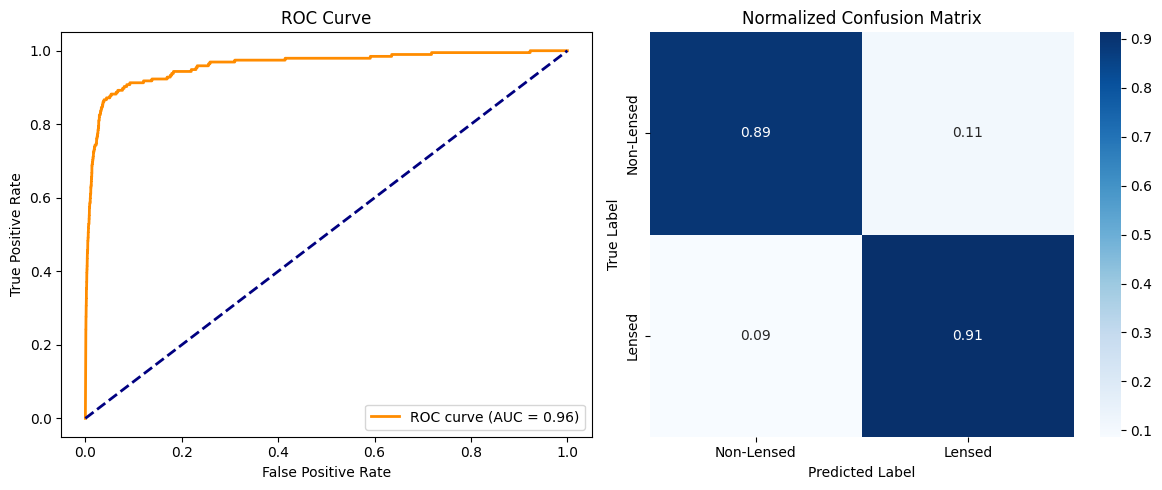

In [211]:
import seaborn as sns

# Create subplots: ROC curve and Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')

sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=["Non-Lensed", "Lensed"], 
            yticklabels=["Non-Lensed", "Lensed"], ax=axes[1])

axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_title("Normalized Confusion Matrix")

# Show both plots
plt.tight_layout()
plt.show()

